In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.fft as fft
import matplotlib as mpl

from torch.distributions.multivariate_normal import MultivariateNormal

In [32]:
plt.style.use('default')
%matplotlib inline

In [33]:
g_cpu = torch.Generator().manual_seed(42)

In [34]:
x, y = 61, 31
n = x * y
gauss_x, gauss_y = 32., 10.
sample_size = int(1e4)

In [35]:
def minmax(ar: torch.Tensor) -> torch.Tensor:
    ma, mi = ar.max(), ar.min()
    return (ar - mi) / (ma - mi)

In [36]:
def gauss_peak(mat_shape=(y, x), loc=(10., 32.),
               cov=torch.Tensor([[10, 0], [0, 10]]),
               n_nsamples=1e3,
               ) -> torch.Tensor:
    y, x = mat_shape
    m = MultivariateNormal(loc=torch.Tensor(loc), covariance_matrix=cov)
    sam_xy = m.sample((int(n_nsamples),)).round().int()
    sam_xy = sam_xy[(0 <= sam_xy[:, 1]) & (sam_xy[:, 1] < y)
                    & (0 <= sam_xy[:, 0]) & (sam_xy[:, 0] < x)]
    sam_flat = sam_xy @ torch.Tensor([[1], [x]]).int().flatten()
    sam_count = sam_flat.bincount(minlength=x * y)
    gauss = sam_count.view((y, x)).float()
    return gauss / gauss.max()


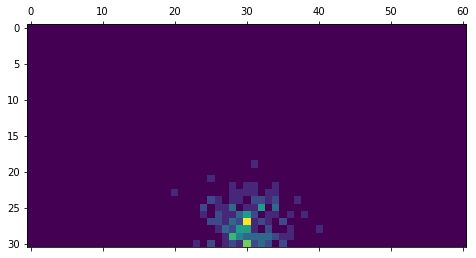

In [40]:
peak = gauss_peak(loc=(30, 28), n_nsamples=200)
plt.matshow(peak, vmin=0, vmax=1)

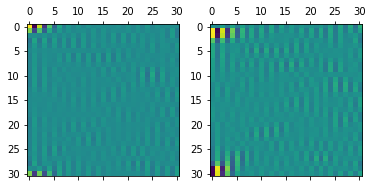

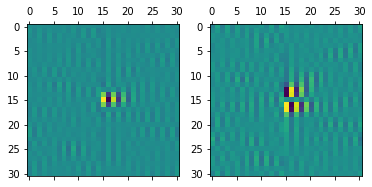

In [41]:
f1 = fft.rfft2(peak)
f2 = fft.fftshift(f1)

for f in [f1, f2]:
    fig, axes = plt.subplots(1, 2)
    axes[0].matshow(f.real)
    axes[1].matshow(f.imag)

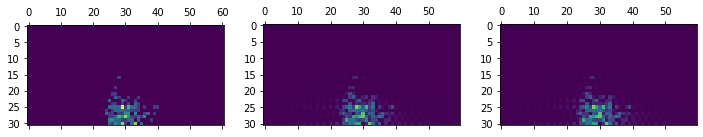

In [18]:
f3 = fft.irfft2(f1)
f4 = fft.irfft2(fft.ifftshift(f2))

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for f, ax in zip([peak, f3, f4], axes):
    ax.matshow(f, vmin=0, vmax=1)

## late simple summary
- throw `torch.fft.rfft2` onto the contact map
- gives a half-size matrix of complex numbers
- do not discard the `.imag` part!
- get the reconstructed map via `torch.fft.irfft2`
- use `fftshift` only with `ifftshift`
- `fftshift` makes no actual difference but might be easier to understand

## re-implemented array reconstructor
- todo: subtract a constant? *still* filter out high-frequency stuff

torch.Size([31, 61]) -> torch.Size([31, 60])


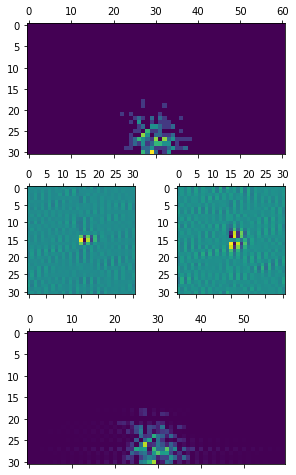

In [21]:
def array_reconstructor(peak, figsize=(4, 8.4)):
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = mpl.gridspec.GridSpec(4, 2, figure=fig)
    fig.add_subplot(gs[0, :]).matshow(peak, vmin=0, vmax=1)

    f1 = torch.fft.rfft2(peak)
    f2 = torch.fft.fftshift(f1)

    # f2_clone = f2.clone()
    # h, w = f2_clone.shape
    # center = h * w // 2
    # assert f2_clone.real.argmax() == center
    # f2_clone.real[h // 2, w // 2] = 0

    fig.add_subplot(gs[1, 0]).matshow(f2.real)
    fig.add_subplot(gs[1, -1]).matshow(f2.imag)

    f4 = fft.irfft2(fft.ifftshift(f2))
    fig.add_subplot(gs[2, :]).matshow(f4, vmin=0, vmax=1)
    print(peak.shape, '->', f4.shape)


peak = gauss_peak(loc=(30, 28), n_nsamples=200)
array_reconstructor(peak)

In [15]:
peak.max(), peak.min(), peak.std(), peak.mean()

(tensor(1.), tensor(0.), tensor(0.0804), tensor(0.0134))

In [14]:
301 * 151 // 2

22725

torch.Size([31, 61]) -> torch.Size([31, 60])


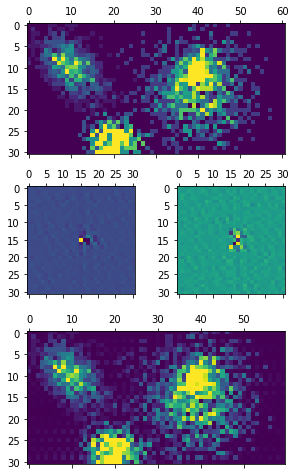

In [15]:
gauss = gauss_peak(loc=(10, 10), n_nsamples=1e3,
                   cov=torch.Tensor([[16, 8], [8, 16]]))
gauss += 2 * gauss_peak(loc=(20, 28), n_nsamples=400)
gauss += gauss_peak(loc=(40, 10), n_nsamples=1000,
                    cov=torch.Tensor([[4, -1], [-1, 4]]))
gauss += 1.6 * gauss_peak(loc=(40, 15), n_nsamples=1000,
                          cov=torch.Tensor([[40, 0], [0, 40]]))

_ = array_reconstructor(gauss)

torch.Size([31, 61]) -> torch.Size([31, 60])


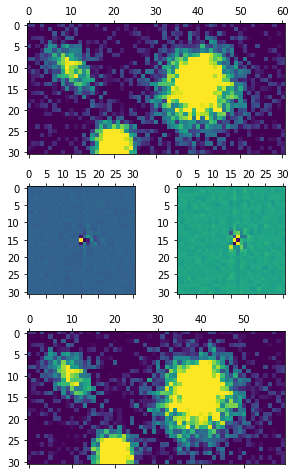

In [17]:
noise = torch.rand((y, x), generator=g_cpu)
argauss = gauss - .4 + .6 * noise
array_reconstructor(argauss)

In [528]:
argauss

tensor([[-0.1188, -0.0161,  0.0278,  ..., -0.0105,  0.0900, -0.0217],
        [-0.1131,  0.2178, -0.0688,  ...,  0.1832, -0.1675,  0.1475],
        [-0.0660,  0.2013,  0.1962,  ...,  0.1392, -0.3299,  0.0335],
        ...,
        [-0.2701, -0.2352, -0.0004,  ...,  0.0274,  0.1558, -0.0925],
        [-0.1710, -0.1485, -0.2071,  ...,  0.0997,  0.1356, -0.2410],
        [-0.2168, -0.1699, -0.2535,  ..., -0.3894, -0.3505, -0.1631]])

In [529]:
share = .1
lower, upper = torch.quantile(argauss, q=torch.Tensor([share / 2, 1 - share / 2]),
                              keepdim=False)
lower, upper

(tensor(-0.3425), tensor(0.6842))

'But the filter must be applied to the spectrum of course - not the image!'

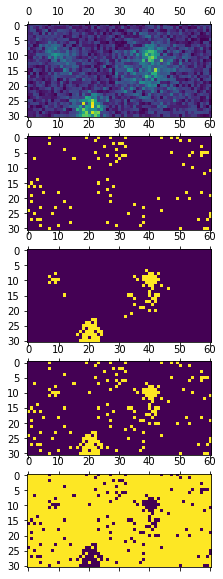

In [530]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(4, 10))
ax0.matshow(argauss)
ax1.matshow(argauss <= lower)
ax2.matshow(argauss >= upper)
ax3.matshow((argauss <= lower) | (argauss >= upper))
ax4.matshow((lower < argauss) & (argauss < upper))
'But the filter must be applied to the spectrum of course - not the image!'

torch.Size([31, 61]) -> torch.Size([31, 60])
46.8516960144043


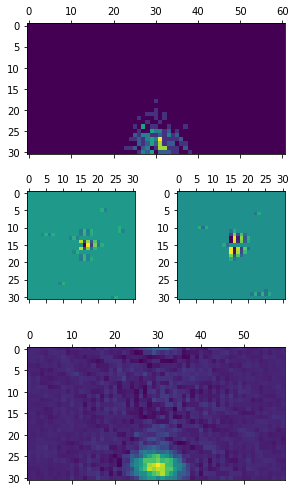

In [43]:
def array_reconstructor_threshold(peak, share=.01, figsize=(4, 11)):
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = mpl.gridspec.GridSpec(5, 2, figure=fig)
    fig.add_subplot(gs[0, :]).matshow(peak)  # , vmin=0, vmax=1)

    f1 = torch.fft.rfft2(peak)
    f1[0, 0] = 0
    f2 = torch.fft.fftshift(f1)

    # fig.add_subplot(gs[1, 0]).matshow(f2.real)
    # fig.add_subplot(gs[1, -1]).matshow(f2.imag)
    #
    # f3 = fft.irfft2(fft.ifftshift(f2))
    # fig.add_subplot(gs[2, :]).matshow(f3, vmin=0, vmax=1)

    f4 = f2.clone()
    for f in [f4.real, f4.imag]:
        lower, upper = torch.quantile(
            f, q=torch.Tensor([share / 2, 1 - share / 2]), keepdim=False)
        f[(lower < f) & (f < upper)] = 0

    fig.add_subplot(gs[1, 0]).matshow(f4.real)
    fig.add_subplot(gs[1, -1]).matshow(f4.imag)

    f5 = fft.irfft2(fft.ifftshift(f4))
    fig.add_subplot(gs[2, :]).matshow(f5)  # , vmin=0, vmax=1)
    print(peak.shape, '->', f5.shape)
    print(f5.max().item())
    return f5


peak = gauss_peak(loc=(30, 28), n_nsamples=200)
ppeak = peak + .4
ppeak = peak * 100 - 2

_ = array_reconstructor_threshold(ppeak, share=.05)

torch.Size([31, 61]) -> torch.Size([31, 60])
89.31122589111328


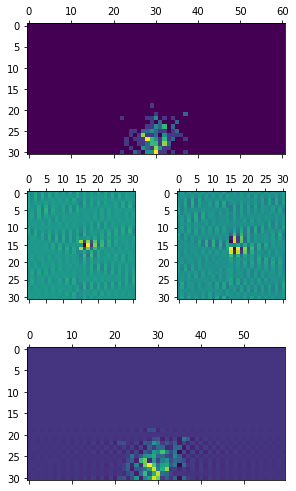

In [30]:
_ = array_reconstructor_threshold(ppeak, share=1)

torch.Size([31, 61]) -> torch.Size([31, 60])
65.55669403076172


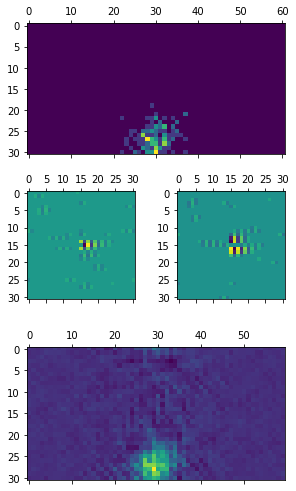

In [29]:
_ = array_reconstructor_threshold(ppeak, share=.1)

torch.Size([31, 61]) -> torch.Size([31, 60])


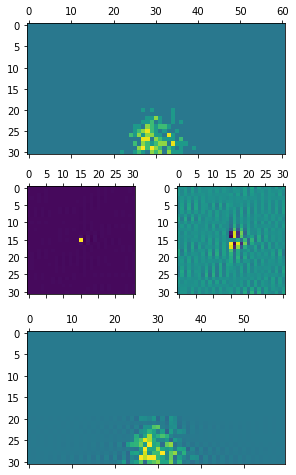

In [533]:
peak = gauss_peak(loc=(30, 28), n_nsamples=200) + .4
array_reconstructor(peak)

torch.Size([31, 61]) -> torch.Size([31, 60])
0.8232322931289673


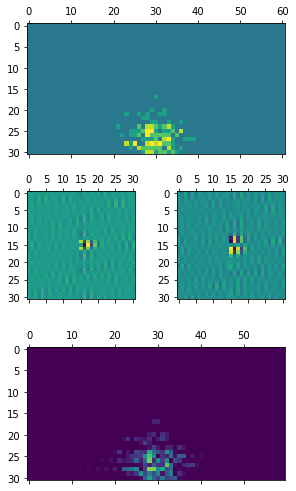

In [503]:
_ = array_reconstructor_threshold(peak, share=1)

torch.Size([1001, 1001]) -> torch.Size([1001, 1000])
1.194559097290039


(tensor(2.4390e-10), tensor(0.0002), tensor(1.1946))

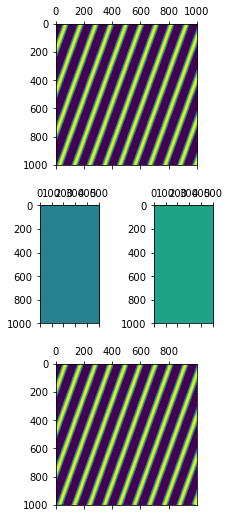

In [504]:
w = np.arange(-500, 501, 1)
X, Y = np.meshgrid(w, w)
wavelength = 100
angle = np.pi / 9
grating = np.sin(2 * np.pi * (X * np.cos(angle) + Y * np.sin(angle)) / wavelength)

f5 = array_reconstructor_threshold(torch.Tensor(grating), figsize=(3, 11), share=.01)
torch.mean(f5), torch.sum(f5), torch.max(f5)

torch.Size([31, 61]) -> torch.Size([31, 60])
0.9057181477546692


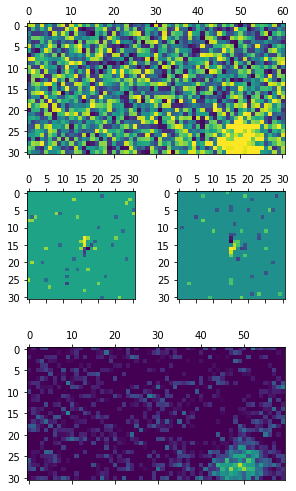

In [505]:
peak = gauss_peak(loc=(50, 28), n_nsamples=10000) + noise
f5 = array_reconstructor_threshold(peak, share=.05)

(301, 301)


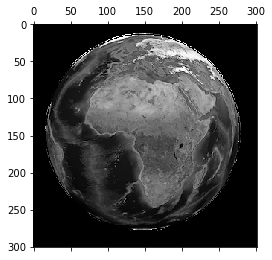

In [507]:
image_filename = 'in/Earth.png'
image = plt.imread(image_filename)
image = image[:, :, :3].mean(axis=2)  # Convert to grayscale
print(image.shape)
plt.matshow(image, cmap='gray')
earth = torch.Tensor(image)

torch.Size([301, 301]) -> torch.Size([301, 300])
0.8630688786506653


tensor(0.8631)

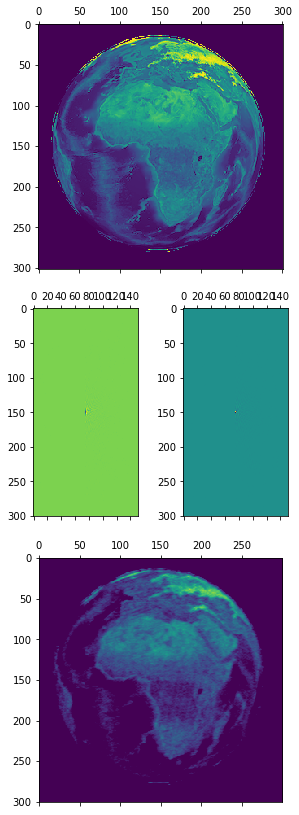

In [508]:
f5 = array_reconstructor_threshold(earth, figsize=(4, 18), share=.05)
torch.max(f5)

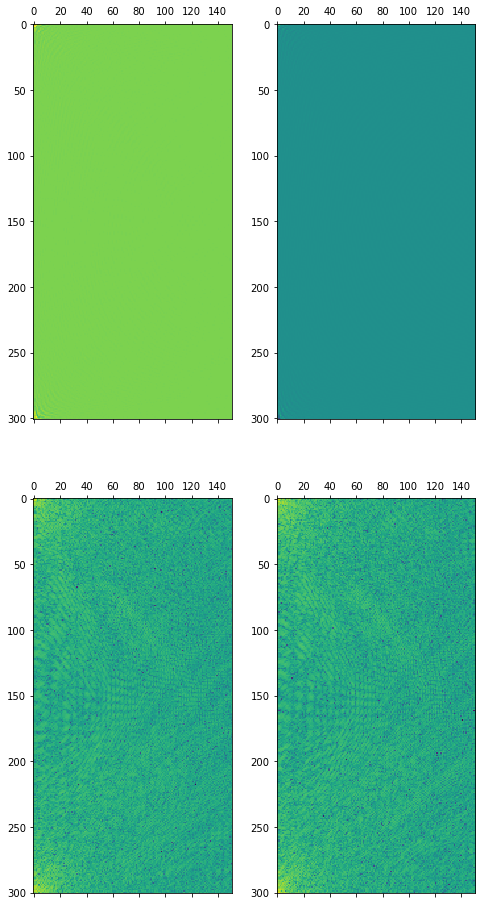

In [509]:
f1 = fft.rfft2(earth)
f1[0, 0] = 0
f2 = fft.fftshift(f1)
fig, axes = plt.subplots(2, 2, figsize=(8, 16))

axes[0, 0].matshow(f1.real)
axes[0, 1].matshow(f1.imag)
axes[1, 0].matshow(torch.log(torch.abs(f1.real)))
axes[1, 1].matshow(torch.log(torch.abs(f1.imag)))

In [510]:
noise = torch.rand((y, x), generator=g_cpu)

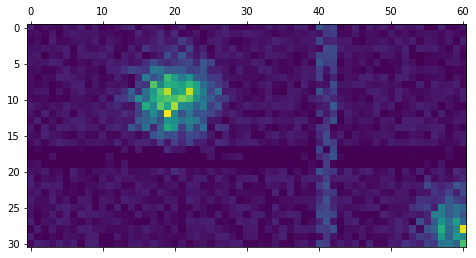

In [511]:
ngauss = gauss_peak(loc=(60, 28), n_nsamples=1000)
ngauss += gauss_peak(loc=(20, 10), n_nsamples=1000)
ngauss[17:20, :] -= .3 * torch.rand((3, x), generator=g_cpu)
nnoisy = ngauss + .1 * noise
nnoisy = torch.clamp(nnoisy, min=0)
nnoisy[:, 40:43] = torch.clamp(.3 * torch.rand((y, 3), generator=g_cpu), min=0)
plt.matshow(nnoisy)

torch.Size([31, 61]) -> torch.Size([31, 60])


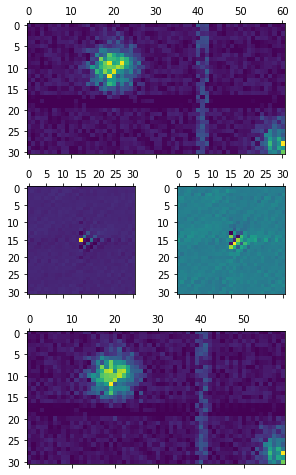

In [512]:
array_reconstructor(nnoisy)

torch.Size([31, 61]) -> torch.Size([31, 60])
0.795617401599884


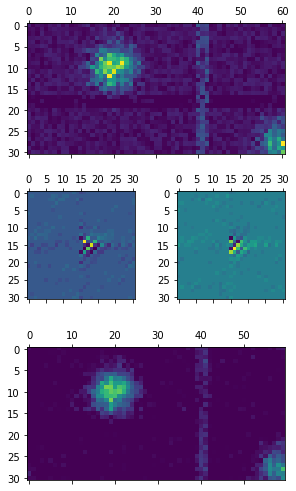

In [514]:
_ = array_reconstructor_threshold(nnoisy, share=.2)

torch.Size([31, 61]) -> torch.Size([31, 60])
0.7306424975395203


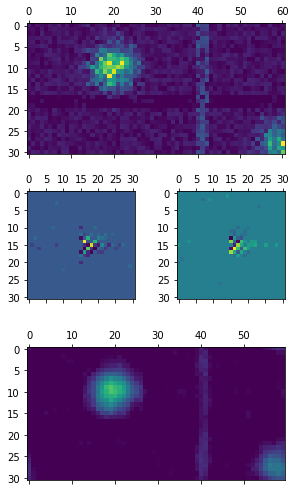

In [515]:
_ = array_reconstructor_threshold(nnoisy, share=.05)

torch.Size([31, 61]) -> torch.Size([31, 60])
0.27340269088745117


(tensor(-1.4420e-10), tensor(0.2734))

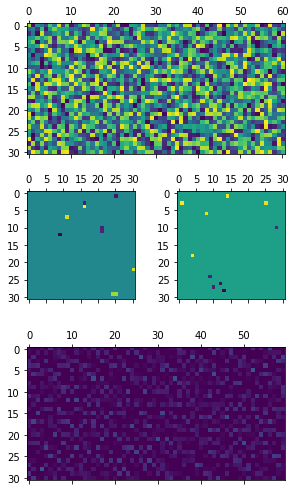

In [516]:
noise.max(), noise.mean()
f5 = array_reconstructor_threshold(noise)
torch.mean(f5), torch.max(f5)

torch.Size([31, 61]) -> torch.Size([31, 60])
0.6479969620704651


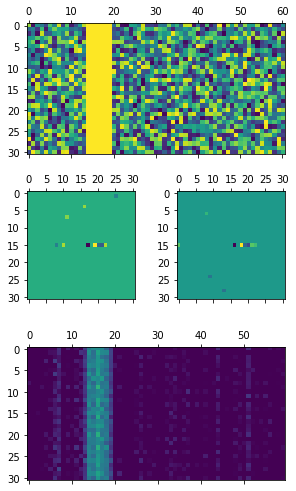

In [517]:
noi = noise.clone()
noi[:, 14:20] = 1
_ = array_reconstructor_threshold(noi)

In [48]:
def arrays(ar):
    plt.matshow(ar, vmin=0)
    L = ar.shape[1] // 2

    fhat = torch.fft.fft(ar)
    psd = torch.real(fhat * torch.conj(fhat) / n)
    plt.matshow(psd[:, list(range(-L, L))], vmin=0)

    psd = torch.fft.fft(ar).float()
    plt.matshow(psd[:, list(range(-L, L))], vmin=0)


def array_reconstruction(ar, t=.001):
    plt.matshow(ar, vmin=0)
    L = ar.shape[1] // 2

    fhat = torch.fft.fft(ar)
    psd = torch.real(fhat * torch.conj(fhat) / n)
    plt.matshow(psd[:, list(range(-L, L))], vmin=0)

    psd2 = torch.fft.fft(ar).real
    plt.matshow(torch.fft.fftshift(psd2), vmin=0)

    indices = (psd > t)
    print(indices.count_nonzero())
    plt.matshow(indices, vmin=0)

    psd_clean = psd * indices
    fhat_n = indices * fhat
    ffilt = torch.fft.ifft(fhat_n)
    plt.matshow(ffilt.real.float(), vmin=0)


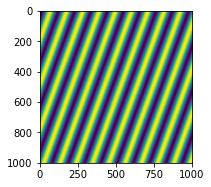

In [49]:
import numpy as np
import matplotlib.pyplot as plt

w = np.arange(-500, 501, 1)
X, Y = np.meshgrid(w, w)
wavelength = 100
angle = np.pi / 9
grating = np.sin(
    2 * np.pi * (X * np.cos(angle) + Y * np.sin(angle)) / wavelength
)
# plt.set_cmap("gray")
plt.subplot(121)
plt.imshow(grating)

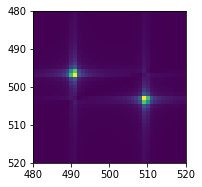

In [50]:
# Calculate Fourier transform of grating
ft = np.fft.ifftshift(grating)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)
plt.subplot(122)
plt.imshow(abs(ft))
plt.xlim([480, 520])
plt.ylim([520, 480])  # Note, order is reversed for y
plt.show()

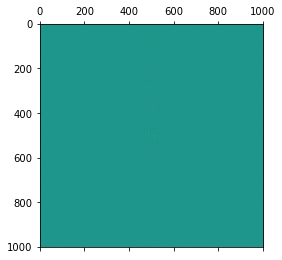

In [51]:
ft = torch.fft.ifftshift(torch.Tensor(grating))
ft = torch.fft.fft2(ft)
ft = np.fft.fftshift(ft)
plt.matshow(ft.real)

In [52]:
plt.matshow(torch.fft.rfft2(argauss).imag)

NameError: name 'argauss' is not defined

(301, 301)


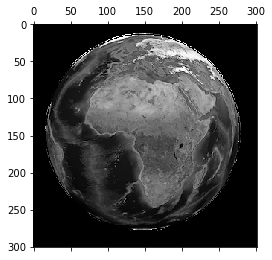

In [53]:
image_filename = 'in/Earth.png'
image = plt.imread(image_filename)
image = image[:, :, :3].mean(axis=2)  # Convert to grayscale
print(image.shape)
plt.matshow(image, cmap='gray')
earth = torch.Tensor(image)

tensor(22809)


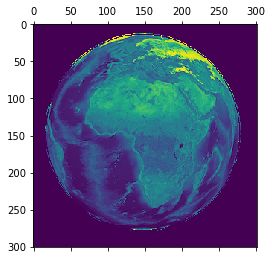

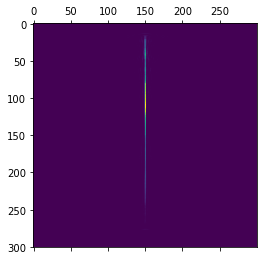

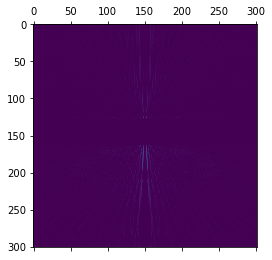

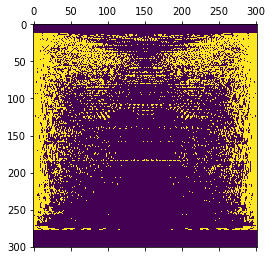

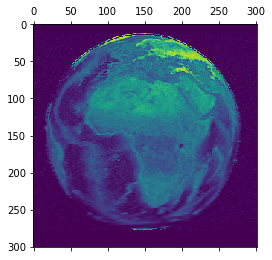

In [54]:
array_reconstruction(earth)

In [56]:
x, y

(61, 31)

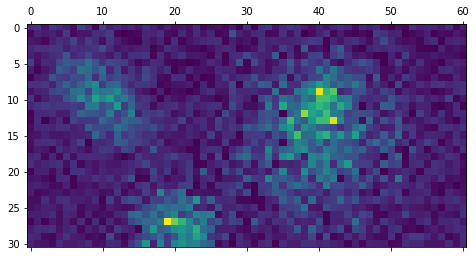

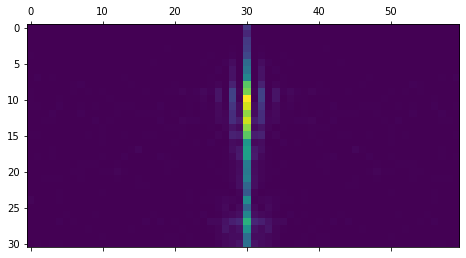

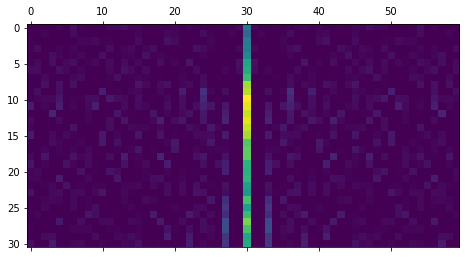

In [57]:
noise = torch.rand((y, x), generator=g_cpu)
noisy = gauss + .3 * noise
arrays(noisy)

In [58]:
ngauss = gauss_peak(loc=(60, 28), n_nsamples=100)
ngauss += gauss_peak(loc=(20, 10), n_nsamples=100)
ngauss[17:20, :] -= .3 * torch.rand((3, x), generator=g_cpu)
nnoisy = ngauss + .1 * noise
nnoisy = torch.clamp(nnoisy, min=0)
nnoisy[:, 40:43] = torch.clamp(.3 * torch.rand((y, 3), generator=g_cpu), min=0)

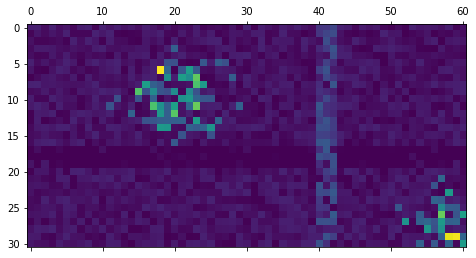

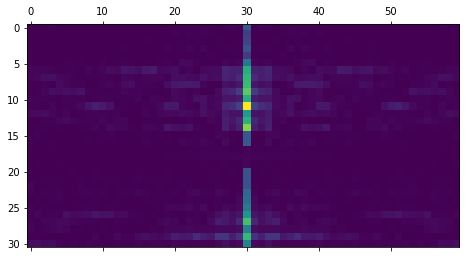

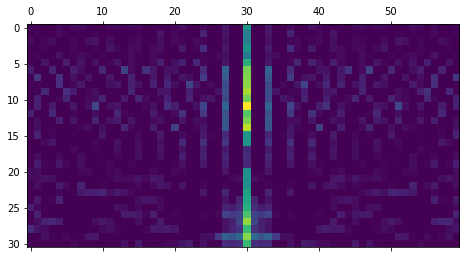

In [59]:
arrays(nnoisy)

tensor(289)


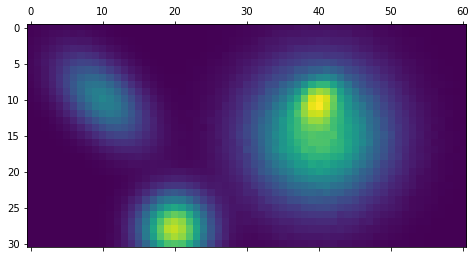

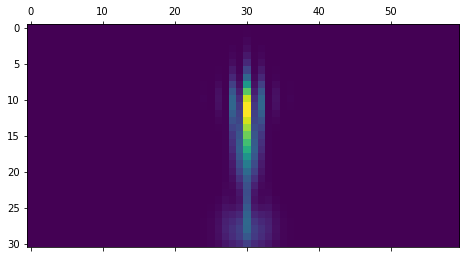

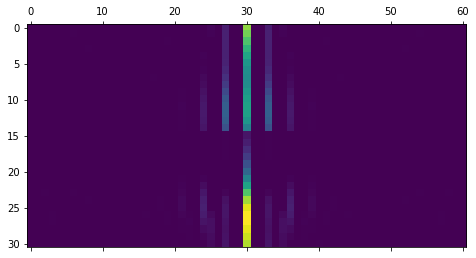

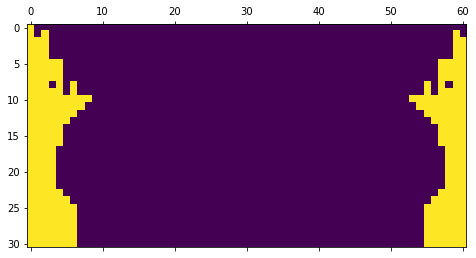

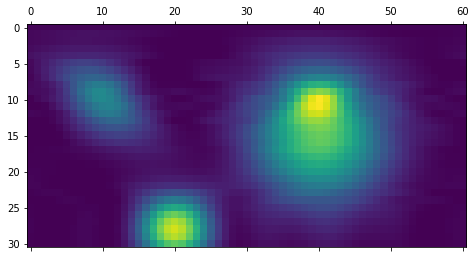

In [60]:
g2 = gauss_peak(loc=(10, 10), n_nsamples=1e6, cov=torch.Tensor([[16, 8], [8, 16]]))
g2 += 2 * gauss_peak(loc=(20, 28), n_nsamples=4 * 1e5)
g2 += gauss_peak(loc=(40, 10), n_nsamples=1e6, cov=torch.Tensor([[4, -1], [-1, 4]]))
g2 += 1.6 * gauss_peak(loc=(40, 15), n_nsamples=1e6, cov=torch.Tensor([[40, 0], [0, 40]]))

array_reconstruction(g2)

tensor(31)


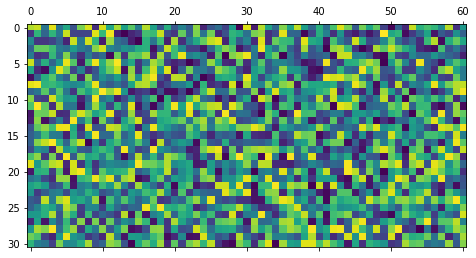

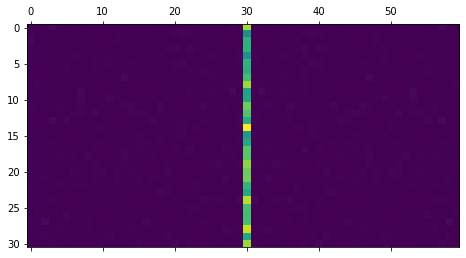

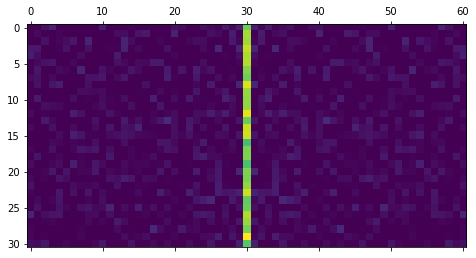

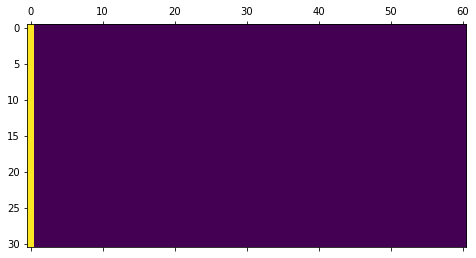

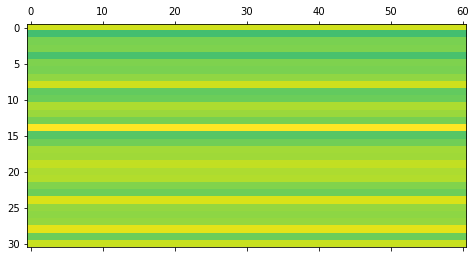

In [61]:
array_reconstruction(noise, t=.03)

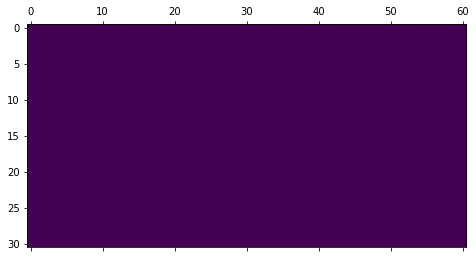

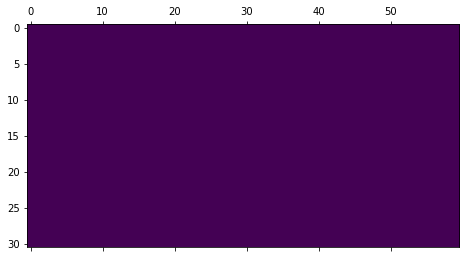

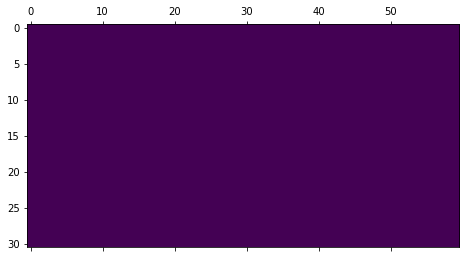

In [62]:
arrays(torch.zeros_like(gauss))

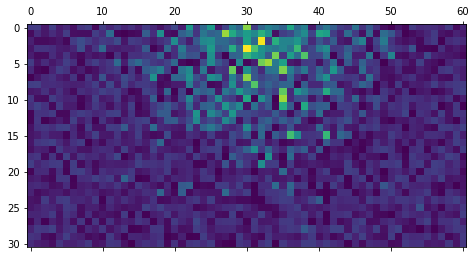

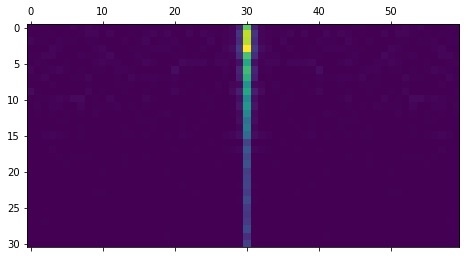

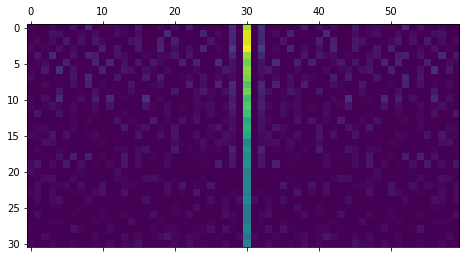

In [63]:
ar2 = gauss_peak(loc=(32, 2),
                 n_nsamples=1000,
                 cov=torch.Tensor([[80, 0], [0, 80]])
                 )

arrays(5 * ar2 + noise)

In [64]:
plt.matshow(psd > 2 * 1e-3, vmin=0)

NameError: name 'psd' is not defined

In [ ]:
ar = argauss
L = ar.shape[1] // 2

fhat = torch.fft.fft(ar)
psd = torch.real(fhat * torch.conj(fhat) / n)

psd2 = torch.fft.fft(ar).real.float()

In [ ]:
# plt.matshow(psd)
# psd, fhat = psd2, psd2
# plt.matshow(psd2, vmin=0)

In [ ]:
indices = (psd > .001)
print(indices.count_nonzero())
plt.matshow(indices, vmin=0)
psd_clean = psd * indices
fhat_n = indices * fhat
ffilt = torch.fft.ifft(fhat_n)
plt.matshow(ffilt.real.float(), vmin=0)
plt.matshow(ar)

In [ ]:
import seaborn as sns

[None, (1e-05, 0.4061139797146661)]

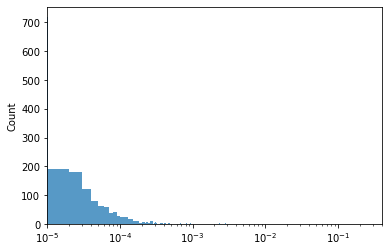

In [128]:
ax = sns.histplot(psd.flatten())
ax.set(xscale='log', xlim=(1e-5, None))

[None, (0.002, 0.4061139797146661), (0.0, 10.0)]

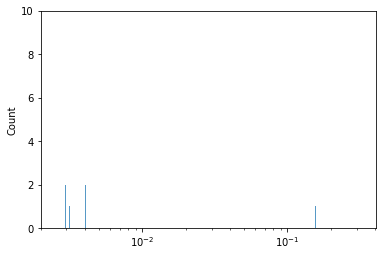

In [129]:
ax = sns.histplot(psd.flatten())
ax.set(xscale='log', xlim=(2 * 1e-3, None), ylim=(0, 10))

In [130]:
psd.sum()

tensor(3.4226)

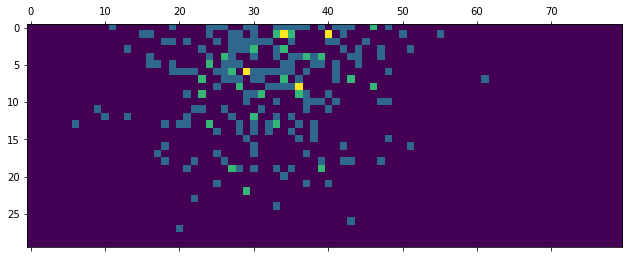

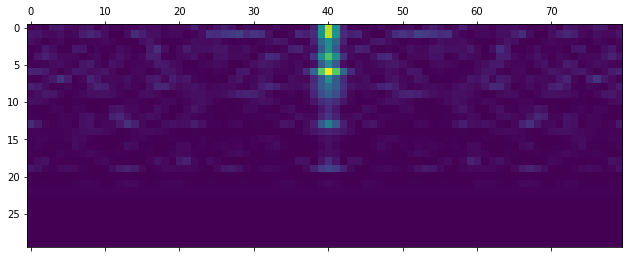

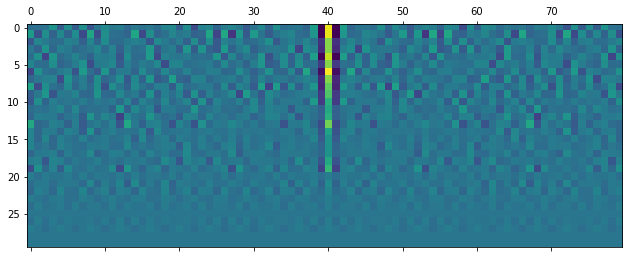

In [680]:
arrays(argauss)

In [677]:
argauss.shape

torch.Size([30, 80])